# Generate the `doctors` dataset


TODOs:
- [ ] Fill out other variables with realistic values


In [1]:
datafilepath = "../datasets/doctors.csv"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from scipy.stats import norm

In [4]:
from faker import Faker
faker = Faker()


names = faker.name()

## Dataset design choices


In [5]:
# number of observations
nR = 68
nU = 156
n = nR + nU
n

224

## Generate names and permit numbers

In [6]:
Faker.seed(301)
names = [faker.name() for _ in range(0,n)]

Faker.seed(3001)
permits = [faker.unique.random_int(min=20202, max=100110) for _ in range(0,n)]

assert len(set(permits)) == len(permits), "permits should be unique"

## Generate sleep scores

In [7]:
# Rural doctors sleep score
muR = 82
sigmaR = 6
scoreR = norm(muR, sigmaR)

# Urband doctors sleep score
muU = 80
sigmaU = 6
scoreU = norm(muU, sigmaU)

In [8]:
# Generate sleep scores

np.random.seed(290)
scoresR = scoreR.rvs(nR)
scoresR = scoresR.round(0)

np.random.seed(291)
scoresU = scoreU.rvs(nU)
scoresU = scoresU.round(0)

data = {
    "permit": permits,
    "name": names,
    "location": ["urban"]*nU + ["rural"]*nR,
    "score": list(scoresU) + list(scoresR),
}

doctors = pd.DataFrame(data)

np.random.seed(11)
doctors = doctors.sample(frac=1).reset_index(drop=True)

doctors.head()

,permit,name,location,score
0,93636,Yesenia Smith,urban,82.0
1,79288,Andrew Stanley,rural,85.0
2,94980,Jessica Castro,rural,97.0
3,99441,Jasmine Lynch,urban,74.0
4,92882,Cassie Pena,urban,73.0


In [9]:
# Make sure scores don't exceed 100
assert doctors['score'].max() <= 100

In [10]:
doctors.groupby("location")["score"].describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
rural,68.0,81.794118,6.008846,71.0,77.0,80.0,86.25,98.0
urban,156.0,79.570513,6.130950,65.0,75.0,79.0,83.00,96.0


In [11]:
# # SAVE TO DATAFILE
# doctors.to_csv(datafilepath, index=False)

In [12]:
# RELOAD FROM DATAFILE
doctors = pd.read_csv(datafilepath)
doctors.head()

,permit,name,location,score
0,93636,Yesenia Smith,urban,82.0
1,79288,Andrew Stanley,rural,85.0
2,94980,Jessica Castro,rural,97.0
3,99441,Jasmine Lynch,urban,74.0
4,92882,Cassie Pena,urban,73.0


### Descriptive stduplicatedstics checks

In [13]:
doctors.groupby("location")["score"].describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
rural,68.0,81.794118,6.008846,71.0,77.0,80.0,86.25,98.0
urban,156.0,79.570513,6.130950,65.0,75.0,79.0,83.00,96.0


### Visual inspection

<AxesSubplot:xlabel='score', ylabel='Density'>

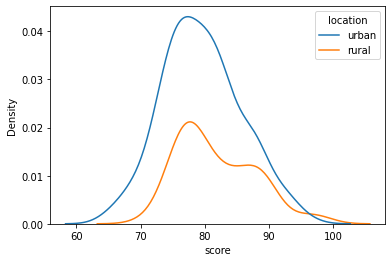

In [14]:
sns.kdeplot(x="score", hue="location", data=doctors)

<AxesSubplot:xlabel='score', ylabel='location'>

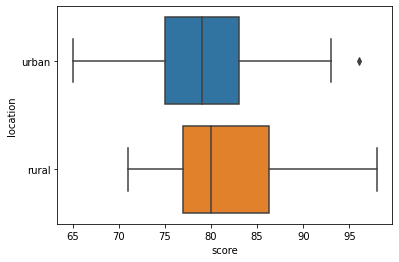

In [15]:
sns.boxplot(x="score", y="location", data=doctors)

## Tests

In [16]:
from scipy.stats import t as tdist

def calcdf(stdX, n, stdY, m):
    vX = stdX**2 / n
    vY = stdY**2 / m
    df = (vX+vY)**2 / (vX**2/(n-1) + vY**2/(m-1))
    return df

def ttest(sampleA, sampleB, pooled=False):
    """
    T-test to detect difference between means in two samples.
    """
    # 1. calculate the mean in each group
    meanA, meanB = np.mean(sampleA), np.mean(sampleB)
    # 2. calculate d, the observed difference between means
    d = meanA - meanB
    # 3. calculate the standard deviations in each group
    stdA, stdB = np.std(sampleA, ddof=1), np.std(sampleB, ddof=1)
    nA, nB = len(sampleA), len(sampleB)
    if pooled:
        # 4. compute the pooled variance and standard error
        var_pooled = ((nA-1)*stdA**2 + (nB-1)*stdB**2)/(nA + nB - 2)
        std_pooled = np.sqrt(var_pooled)
        stdD = std_pooled * np.sqrt(1/nA + 1/nB)
        # 5. degrees of freedom
        df = nA + nB - 2
    else:
        # 4'. compute the unpooled standard deviation of D
        stdD = np.sqrt(stdA**2/nA + stdB**2/nB)
        # 5'. use crazy formula for the degrees of freedom
        df = calcdf(stdA, nA, stdB, nB)
    # 6. compute the value of the t-statistic
    tstat = d / stdD
    # 7. compute the two-sided p-value for tstat
    pvalue = 2 * tdist(df).cdf(-abs(tstat))
    return tstat, pvalue

In [17]:
scoresR = doctors[doctors["location"]=="rural"]["score"].values
scoresU = doctors[doctors["location"]=="urban"]["score"].values

### Unpooled test (Welch test)

In [18]:
from scipy.stats import ttest_ind
r = ttest_ind(scoresR, scoresU, equal_var=False)
r.statistic, r.pvalue

(2.530869248892873, 0.012570066043998337)

In [19]:
ttest(scoresR, scoresU)

(2.530869248892873, 0.012570066043998337)

### Pooled variance test

In [20]:
r = ttest_ind(scoresR, scoresU)
r.statistic, r.pvalue

(2.510860036908649, 0.012756225363756033)

In [21]:
ttest(scoresR, scoresU, pooled=True)

(2.510860036908649, 0.012756225363756033)